In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install catboost

import warnings, itertools, random, os, re, gc, time
warnings.filterwarnings('ignore')

from collections import Counter
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import *

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.metrics import *

from catboost import CatBoostClassifier

**REGION**: the location of each client

**TENURE**: duration in the network

**MONTANT**: top-up amount

**FREQUENCE_RECH**: number of times the customer refilled

**REVENUE**: monthly income of each client

**ARPU_SEGMENT**: income over 90 days / 3

**FREQUENCE**: number of times the client has made an income

**DATA_VOLUME**: number of connections

**ON_NET**: inter expresso call

**ORANGE**: call to orange

**TIGO**: call to Tigo

**ZONE1**: call to zones1

**ZONE2**: call to zones2

**REGULARITY**: number of times the client is active for 90 days

**TOP_PACK**: the most active packs

**FREQ_TOP_PACK**: number of times the client has activated the top pack packages


### **DATA IMPORT**

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/Zindi - Expresso Churn Prediction Challenge/"

In [4]:
time_s_32 = time.time()
train = pd.read_csv(path + "Train.csv")
test = pd.read_csv(path + "Test.csv")
sub = pd.read_csv(path + "SampleSubmission.csv")

train = train.drop(columns=['user_id', 'MRG'])
test = test.drop(columns=['user_id', 'MRG'])

for col in [c for c in train.columns if c not in ['TOP_PACK', 'REGION', 'TENURE']]:
  train[col] = train[col].astype('float32')
  if col != 'CHURN':
    test[col] = test[col].astype('float32')

time_e_32 = time.time()
time__32 = '{:.1f}'.format(time_e_32-time_s_32)
memory_32 = (train.memory_usage(index = True).sum() + test.memory_usage(index = True).sum())/ 1e9
memory_32_str = '{:.2f}'.format(memory_32)
types_32 = (train.dtypes).value_counts()

print(f'{3*"="} Traditional method with reduce memory {5*"="}\nMemory:\t{memory_32_str} gb\nTime:\t{time__32} sec\n\n{types_32}')

train.head(5)

=== Traditional method with reduce memory =====
Memory:	0.20 gb
Time:	14.6 sec

float32    14
object      3
dtype: int64


REGION         TENURE  ...  FREQ_TOP_PACK  CHURN
0  FATICK   K > 24 month  ...            8.0    0.0
1     NaN  I 18-21 month  ...            NaN    1.0
2     NaN   K > 24 month  ...            1.0    0.0
3   DAKAR   K > 24 month  ...           11.0    0.0
4   DAKAR   K > 24 month  ...            2.0    0.0

[5 rows x 17 columns]

### **DATA ENGINEERING**

In [5]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

data['REVENUE-MONTANT'] = data['REVENUE'] - data['MONTANT']
data['REVENUE/MONTANT'] = data['REVENUE'] / data['MONTANT']
data['TENURE_number'] = data['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 'G 12-15 month':12, 'J 21-24 month': 21, 'F 9-12': 9, 'E 6-9 month':6, 'D 3-6 month':3})
data['TENURE_avg'] = data['TENURE'].map({'K > 24 month': (24+27)/2, 'I 18-21 month':(18+21)/2 , 'H 15-18 month': (15+18)/2, 'G 12-15 month':(12+15)/2, 'J 21-24 month': (21+24)/2, 'F 9-12': (9+12)/2, 'E 6-9 month':(6+9)/2, 'D 3-6 month':(3+6)/2})
data['TENURE/FREQUENCE_RECH'] = data['TENURE_avg'] / data['FREQUENCE_RECH']
data['TENURE/REGULARITY'] = data['TENURE_avg'] / data['REGULARITY']

data['freq*montant'] = data['FREQUENCE'] * data['MONTANT']
data['freq*rech'] = data['FREQUENCE'] * data['FREQUENCE_RECH']
data['freq*revenue'] = data['FREQUENCE'] * data['REVENUE']
data['freq*segment'] = data['FREQUENCE'] * data['ARPU_SEGMENT']

region = data.groupby('REGION').mean()
region = region.drop(columns=['CHURN'])
for i in region.columns:
  if i != 'REGION':
    region[i+'_reg_mean_all'] = region[i]
    region = region.drop(columns=[i])

tenure = data.groupby('TENURE').mean()
tenure = tenure.drop(columns=['CHURN'])
for i in tenure.columns:
  if i != 'TENURE':
    tenure[i+'_tenure_mean_all'] = tenure[i]
    tenure = tenure.drop(columns=[i])

top_pack = data.groupby('TOP_PACK').mean()
top_pack = top_pack.drop(columns=['CHURN'])
for i in top_pack.columns:
  if i != 'TOP_PACK':
    top_pack[i+'_top_pack_mean_all'] = top_pack[i]
    top_pack = top_pack.drop(columns=[i])

data = pd.merge(data, region, on='REGION', how = 'left')
data = pd.merge(data, tenure, on='TENURE', how = 'left')
data = pd.merge(data, top_pack, on='TOP_PACK', how = 'left')

data['freq/montant'] =  data['MONTANT']/ data['FREQUENCE']
data['freq/rech'] = data['FREQUENCE'] / data['FREQUENCE_RECH']
data['freq/revenue'] = data['FREQUENCE'] / data['REVENUE']
data['freq/segment'] = data['FREQUENCE'] / data['ARPU_SEGMENT']

data['data/reg'] = data['DATA_VOLUME'] / data['REGULARITY']
data['net/reg'] = data['ON_NET'] / data['REGULARITY']
data['montant-rech/freq'] = (data['MONTANT'] - data['FREQUENCE_RECH']) / data['FREQUENCE']
data['segment/reg'] = data['ARPU_SEGMENT'] / data['REGULARITY']

data['reg_log'] = np.log1p(data['REGULARITY'])
data['rech_log'] = np.log1p(data['FREQUENCE_RECH'])
data['data_log'] = np.log1p(data['DATA_VOLUME'])
data['montant_log'] = np.log1p(data['MONTANT'])
data['rev_log'] = np.log1p(data['REVENUE'])
data['freq_log'] = np.log1p(data['FREQUENCE'])

data['reglog-montlog'] = data['reg_log'] - data['montant_log']
data['revlog/montlog'] = data['REVENUE'] / data['montant_log']
data['tenure/rechlog'] = data['TENURE_avg'] / data['rech_log']
data['reglog-datalog'] = data['reg_log'] - data['data_log']

data['total_cal'] = data['ON_NET'].fillna(0) + data['ORANGE'].fillna(0) + data['TIGO'].fillna(0) + data['ZONE1'].fillna(0) + data['ZONE2'].fillna(0)
data['avg_total_cal'] = data['total_cal'] / 5

data['null_count'] = data.isnull().sum(axis=1)

data['REGION'] = data['REGION'].fillna('Unknown').astype('str')
data = pd.get_dummies(data, columns=['REGION', 'TENURE'], drop_first=True)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.drop(columns=['TOP_PACK'])

train = data[:ntrain].copy()
test = data[ntrain:].copy()

del(data)
for _ in range(10): gc.collect()
print(train.shape, test.shape)
train.head(5)

(2154048, 135) (380127, 135)


MONTANT  FREQUENCE_RECH  ...  TENURE_J 21-24 month  TENURE_K > 24 month
0   4250.0            15.0  ...                     0                    1
1      NaN             NaN  ...                     0                    0
2   3600.0             2.0  ...                     0                    1
3  13500.0            15.0  ...                     0                    1
4   1000.0             1.0  ...                     0                    1

[5 rows x 135 columns]

In [ ]:
# # Decorrelation (Not Used)

# corr = data.drop(columns=["REGION"	,"TENURE", 'TOP_PACK']).corr()
# corr_no_target = corr.drop(columns=['CHURN'], index=['CHURN'])

# distance = 1 - np.abs(corr_no_target.values)
# distance[np.where(distance < 0)] = 0
# Z = linkage(distance, method='complete')
# label = fcluster(Z, 0.1, criterion='distance')
# print(len(np.unique(label)))

# all_group = {}
# for l in np.unique(label):
#   idx = np.where(label == l)[0]
#   if len(idx) > 1:
#     tmp_corr = corr_no_target.iloc[idx, idx]
#     group_corr = []
#     for c in tmp_corr.columns:
#       t = data[[c, 'CHURN']].replace([np.inf, -np.inf], np.nan).dropna()
#       m_info = f_classif(t[c].values.reshape(-1, 1), t['CHURN'].values.reshape(-1, 1))
#       group_corr.append([m_info[0][0], corr.loc[c, 'CHURN'], c])
#     all_group[l] = np.array(group_corr)

# corr_cols = corr.columns
# print(len(corr_cols))
# for v, k in all_group.items():
#   max = k[:, 0].argmax()
#   corr_cols = [c for c in corr_cols if c not in list(np.delete(k[:, 2], max))]

# data = data[corr_cols+['REGION', 'TENURE', 'TOP_PACK']]

## **SAVE CSV**

In [ ]:
save_path = path + "FILE_GENERATED/"

train.to_csv(save_path + "Train_processing.csv", sep=',', index=False)
test.to_csv(save_path + "Test_processing.csv", sep=',', index=False)

## **NAIVE**

In [ ]:
target = train.pop('CHURN')
inp_tr, inp_val, y_tr, y_val = train_test_split(train, target, test_size=0.05, random_state=42, stratify=target)

model = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.04,
    max_depth=7,
    reg_lambda=125,
    random_seed=42, 
    task_type='GPU',
    devices='0:1',
    eval_metric="AUC",
    )
model.fit(inp_tr, y_tr, eval_set=(inp_val, y_val), early_stopping_rounds=150, verbose=50, use_best_model=True)
res_cat = model.predict_proba(test)

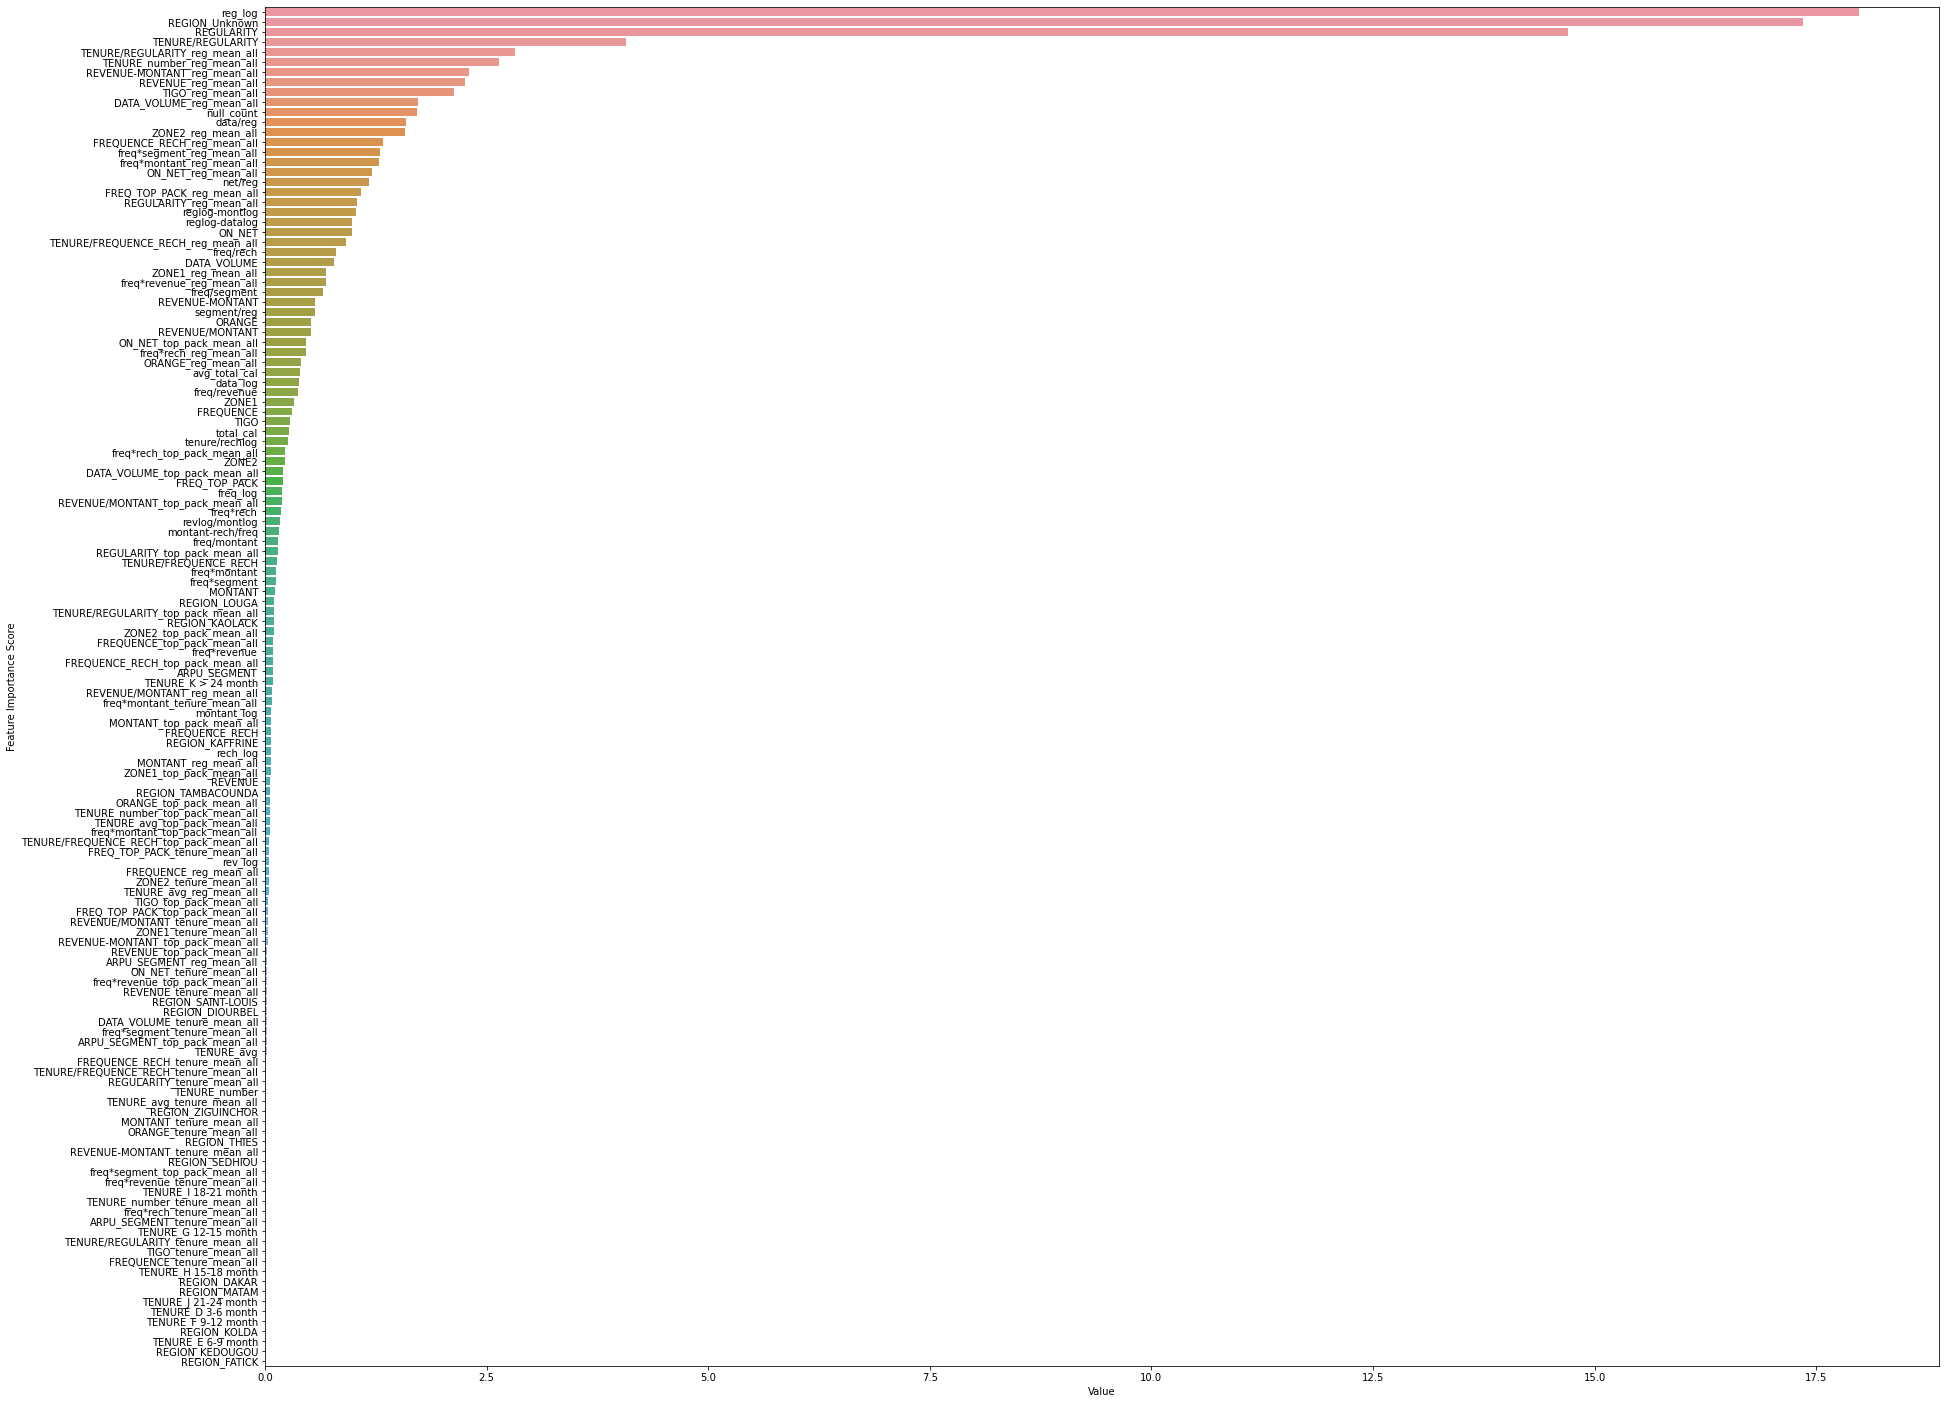

In [ ]:
feat_imp = pd.DataFrame(sorted(zip(model.feature_importances_,inp_tr.columns)), columns=['Value','Feature'])
plt.figure(figsize=(30,25))
sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
plt.ylabel('Feature Importance Score')
plt.show()

In [ ]:
sub.CHURN = res_cat[:, 1]
sub.to_csv("sub.csv", index=False)
sub

user_id     CHURN
0       00001dbe00e56fc4b1c1b65dda63de2a5ece55f9  0.001116
1       000055d41c8a62052dd426592e8a4a3342bf565d  0.077255
2       000081dd3245e6869a4a9c574c7050e7bb84c2c8  0.000648
3       0000b76d2145d9445d9ff6b65c9ebc4196c89337  0.399300
4       0000bae5480628cf8fe51ad84bcb39772fc79224  0.379444
...                                          ...       ...
380122  fffe7e03c7eede2ad0a728ee516c4d342dd16107  0.000739
380123  fffec230e6a1aa51ab37d0051ece42de611e71c6  0.788031
380124  ffff0dcc1ab9812bf205b6d76e9d084053cd96f5  0.230187
380125  ffff91ea6a09a0c8ea42bc6ae33df4b5e06283dc  0.169347
380126  ffffb393b346f5348034e6e22be93778d94d4beb  0.008466

[380127 rows x 2 columns]